# Home Credit Default Risk 3

Kaggle Question:

https://www.kaggle.com/c/home-credit-default-risk/data

This work is to further explore home credit default risk following:

https://github.com/dongzhang84/Kaggle/blob/master/Home_Credit_1.ipynb

https://github.com/dongzhang84/Kaggle/blob/master/Home_Credit_2.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# LightGBM

In [6]:
def model(df_train, df_test, n_folds = 5):

   # Extract the ids
    train_ids = df_train['SK_ID_CURR']
    test_ids = df_test['SK_ID_CURR']

    labels = df_train['TARGET']


    # Remove the ids and target
    df_train = df_train.drop(columns = ['SK_ID_CURR', 'TARGET'])
    df_test = df_test.drop(columns = ['SK_ID_CURR']) 
    
    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test)
    
    
    # Align the dataframes by the columns
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

    print(df_train.shape)
    print(df_test.shape)

    # No categorical indices to record
    cat_indices = 'auto'
    
    print('Training Data Shape: ', df_train.shape)
    print('Testing Data Shape: ', df_test.shape)
    
    feature_names = list(df_train.columns)
    
    # Convert to np arrays
    df_train = np.array(df_train)
    df_test = np.array(df_test)
    
    k_fold = KFold(n_splits = 5, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(df_train.shape[0])

    # Empty array for test predictions
    test_predictions = np.zeros(df_test.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []


    for train_indices, valid_indices in k_fold.split(df_train):
        #print(train_indices.shape, valid_indices.shape)
        train_features, train_labels = df_train[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = df_train[valid_indices], labels[valid_indices]

        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                       class_weight = 'balanced', learning_rate = 0.05, 
                                       reg_alpha = 0.1, reg_lambda = 0.1, 
                                       subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        #print(best_iteration)

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(df_test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
        
    # Submission
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

    return submission, feature_importances, metrics


In [7]:
df_train_control = pd.read_csv('data/application_train.csv')
df_test_control = pd.read_csv('data/application_test.csv')

In [8]:
submission, fi, metrics = model(df_train_control, df_test_control)

(307511, 241)
(48744, 241)
Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798103	train's binary_logloss: 0.548552	valid's auc: 0.760007	valid's binary_logloss: 0.561913
Early stopping, best iteration is:
[269]	train's auc: 0.809199	train's binary_logloss: 0.537755	valid's auc: 0.760273	valid's binary_logloss: 0.555207
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798328	train's binary_logloss: 0.54852	valid's auc: 0.76114	valid's binary_logloss: 0.566651
Early stopping, best iteration is:
[289]	train's auc: 0.812654	train's binary_logloss: 0.534422	valid's auc: 0.761398	valid's binary_logloss: 0.558103
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79964	train's binary_logloss: 0.54685	valid's auc: 0.750232	valid's binary_logloss: 0.564639
Early stopping, best iteration is:
[265]	train's auc: 0.809734	train's 

In [10]:
submission.to_csv('lightGBM_control.csv',index=False)

In [11]:
fi

,feature,importance
0,CNT_CHILDREN,15.0
1,AMT_INCOME_TOTAL,148.2
2,AMT_CREDIT,408.6
3,AMT_ANNUITY,375.6
4,AMT_GOODS_PRICE,320.8
5,REGION_POPULATION_RELATIVE,147.0
6,DAYS_BIRTH,422.8
7,DAYS_EMPLOYED,289.6
8,DAYS_REGISTRATION,217.8
9,DAYS_ID_PUBLISH,269.6


In [12]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


In [15]:
def plot_feature_importances(df):
    
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

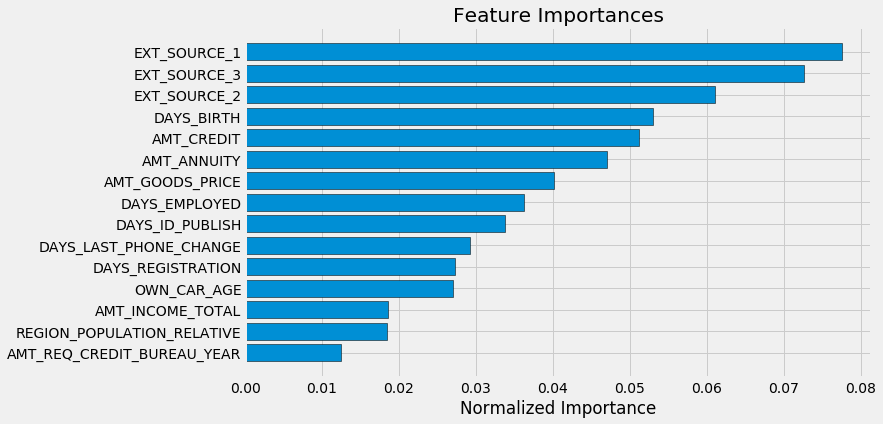

In [17]:
fi_sorted = plot_feature_importances(fi)

In [18]:
ls data

HomeCredit_columns_description.csv* installments_payments.csv*
POS_CASH_balance.csv*               previous_application.csv*
application_test.csv*               sample_submission.csv*
application_train.csv*              test_bureau_corrs_removed.csv
bureau.csv*                         test_bureau_raw.csv
bureau_balance.csv*                 train_bureau_corrs_removed.csv
credit_card_balance.csv*            train_bureau_raw.csv


In [19]:
df_train = pd.read_csv('data/train_bureau_raw.csv')
df_test = pd.read_csv('data/test_bureau_raw.csv')

In [20]:
submission, fi, metrics = model(df_train, df_test)

(307511, 452)
(48744, 452)
Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810464	train's binary_logloss: 0.536973	valid's auc: 0.767228	valid's binary_logloss: 0.552448
Early stopping, best iteration is:
[288]	train's auc: 0.826284	train's binary_logloss: 0.520917	valid's auc: 0.767735	valid's binary_logloss: 0.542548
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810205	train's binary_logloss: 0.537126	valid's auc: 0.767416	valid's binary_logloss: 0.557053
[400]	train's auc: 0.843658	train's binary_logloss: 0.50282	valid's auc: 0.767759	valid's binary_logloss: 0.535467
Early stopping, best iteration is:
[314]	train's auc: 0.830538	train's binary_logloss: 0.516418	valid's auc: 0.768087	valid's binary_logloss: 0.544051
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.811567	train's binary_logloss: 0.535586	valid's

In [22]:
submission.to_csv('lightGBM_2.csv',index=False)

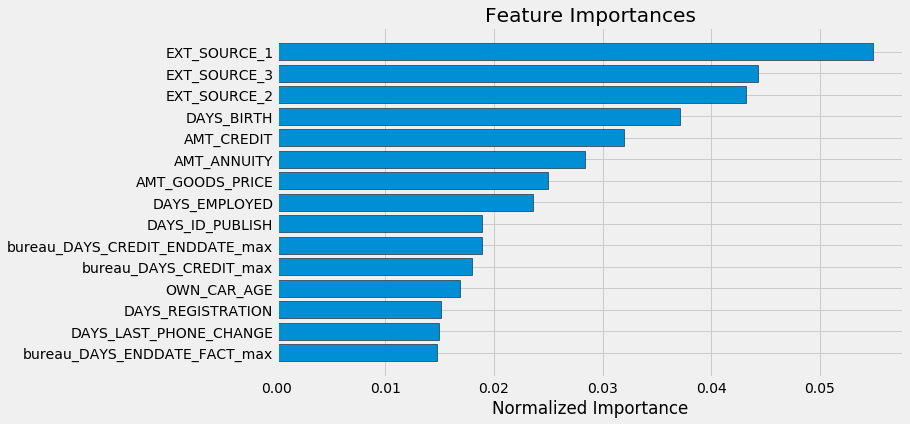

In [23]:
fi_sorted = plot_feature_importances(fi)

In [24]:
df_train_corrs_removed = pd.read_csv('data/train_bureau_corrs_removed.csv')
df_test_corrs_removed = pd.read_csv('data/test_bureau_corrs_removed.csv')

In [25]:
submission, fi, metrics = model(df_train_corrs_removed, df_test_corrs_removed)

(307511, 318)
(48744, 318)
Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806408	train's binary_logloss: 0.540726	valid's auc: 0.764277	valid's binary_logloss: 0.555478
Early stopping, best iteration is:
[239]	train's auc: 0.81357	train's binary_logloss: 0.533542	valid's auc: 0.764746	valid's binary_logloss: 0.550911
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.80644	train's binary_logloss: 0.540834	valid's auc: 0.765114	valid's binary_logloss: 0.559857
Early stopping, best iteration is:
[276]	train's auc: 0.820101	train's binary_logloss: 0.527191	valid's auc: 0.765423	valid's binary_logloss: 0.551358
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.808046	train's binary_logloss: 0.538919	valid's auc: 0.756853	valid's binary_logloss: 0.557036
Early stopping, best iteration is:
[275]	train's auc: 0.82147	train's

In [26]:
submission.to_csv('lightGBM_3.csv',index=False)

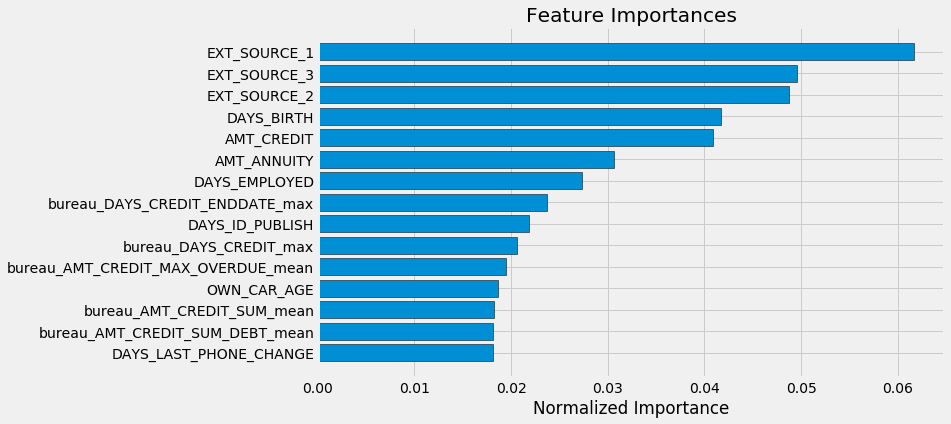

In [27]:
fi_sorted = plot_feature_importances(fi)

In [29]:
metrics

,fold,train,valid
0,0,0.813570,0.764746
1,1,0.820101,0.765423
2,2,0.821470,0.757218
3,3,0.818929,0.765075
4,4,0.825564,0.764379
5,overall,0.819927,0.763358


# XGBoost

In [30]:
from sklearn.model_selection import KFold
import xgboost as xgb

In [32]:
ls data

HomeCredit_columns_description.csv* installments_payments.csv*
POS_CASH_balance.csv*               previous_application.csv*
application_test.csv*               sample_submission.csv*
application_train.csv*              test_bureau_corrs_removed.csv
bureau.csv*                         test_bureau_raw.csv
bureau_balance.csv*                 train_bureau_corrs_removed.csv
credit_card_balance.csv*            train_bureau_raw.csv


In [ ]:
# Load data

df_train = pd.read_csv('data/application_train.csv')
df_test = pd.read_csv('data/application_test.csv')

In [33]:
# Prepare the data

# Extract the ids
train_ids = df_train['SK_ID_CURR']
test_ids = df_test['SK_ID_CURR']

labels = df_train['TARGET']


# Remove the ids and target
df_train = df_train.drop(columns = ['SK_ID_CURR', 'TARGET'])
df_test = df_test.drop(columns = ['SK_ID_CURR']) 

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)


# Align the dataframes by the columns
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

print(df_train.shape)
print(df_test.shape)


print('Training Data Shape: ', df_train.shape)
print('Testing Data Shape: ', df_test.shape)

feature_names = list(df_train.columns)

# Convert to np arrays
df_train = np.array(df_train)
df_test = np.array(df_test)

(307511, 241)
(48744, 241)
Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)


In [34]:
k_fold = KFold(n_splits = 5, shuffle = False, random_state = 50)
    
# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(df_train.shape[0])

# Empty array for test predictions
test_predictions = np.zeros(df_test.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

In [38]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

In [42]:
for train_indices, valid_indices in k_fold.split(df_train):
    #print(train_indices.shape, valid_indices.shape)
    train_features, train_labels = df_train[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = df_train[valid_indices], labels[valid_indices]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
                  'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}


    d_train = xgb.DMatrix(train_features, train_labels)
    d_valid = xgb.DMatrix(valid_features, valid_labels)
    d_test =  xgb.DMatrix(df_test)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    # https://www.rdocumentation.org/packages/xgboost/versions/1.0.0.2/topics/xgb.train

    model = xgb.train(xgb_params, d_train, 50,  watchlist,
                      maximize=True, verbose_eval=50, early_stopping_rounds=100)
                        
    #xgb_pred = model.predict(d_test)
    #xgb_preds.append(list(xgb_pred))
    
    # Record the feature importances
    feature_importance_values += model.feature_importances_ / k_fold.n_splits

    # Make predictions
    test_predictions += model.predict_proba(d_test)[:, 1] / k_fold.n_splits
    
    print(test_predictions[:10])

AttributeError: module 'xgboost' has no attribute 'fit'

In [44]:
from xgboost import XGBClassifier


xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
              'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}


# instantiate the classifier 
xgb = XGBClassifier(**xgb_params)


# fit the classifier to the training data
xgb.fit(df_train, labels)

KeyboardInterrupt: 

In [45]:
from xgboost.sklearn import XGBClassifier


xgb = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=200)

xgb.fit(df_train, labels)

KeyboardInterrupt: 

In [51]:
df_train

array([[0.0000000e+00, 2.0250000e+05, 4.0659750e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.7000000e+05, 1.2935025e+06, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.7500000e+04, 1.3500000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.5300000e+05, 6.7766400e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.7100000e+05, 3.7010700e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.5750000e+05, 6.7500000e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]])

In [49]:
labels.shape

(307511,)